## Tweet Emotion Recognition with TensorFlow


## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [72]:
!pip install nlp

You should consider upgrading via the 'C:\Users\akhil\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [73]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


In [74]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [75]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [76]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [77]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [78]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [79]:
tweets, labels = get_tweets(train)

In [80]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizing the tweets

In [81]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(tweets)

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

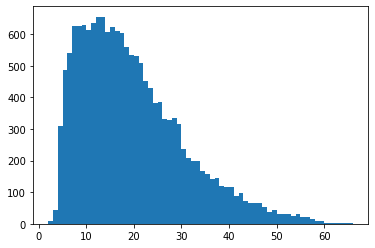

In [82]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [83]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [84]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [85]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [86]:
classes = set(labels)
print(classes)

{'love', 'fear', 'sadness', 'anger', 'surprise', 'joy'}


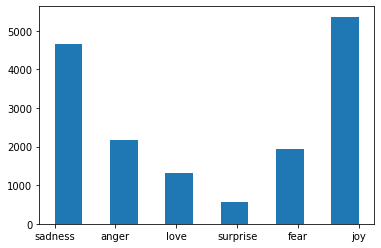

In [87]:
plt.hist(labels, bins=11)
plt.show()

In [88]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [89]:
classes_to_index

{'love': 0, 'fear': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'joy': 5}

In [90]:
index_to_classes

{0: 'love', 1: 'fear', 2: 'sadness', 3: 'anger', 4: 'surprise', 5: 'joy'}

In [91]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [92]:
train_labels = names_to_ids(labels)

## Creating and Compiling the Model

In [93]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [94]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [95]:
history = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
500/500 [==============================] - 12s 17ms/step - loss: 1.2877 - accuracy: 0.4736 - val_loss: 0.7737 - val_accuracy: 0.7170
Epoch 2/10
500/500 [==============================] - 7s 14ms/step - loss: 0.5919 - accuracy: 0.7841 - val_loss: 0.5918 - val_accuracy: 0.8050
Epoch 3/10
500/500 [==============================] - 7s 14ms/step - loss: 0.3495 - accuracy: 0.8824 - val_loss: 0.4812 - val_accuracy: 0.8360
Epoch 4/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2291 - accuracy: 0.9197 - val_loss: 0.4362 - val_accuracy: 0.8730
Epoch 5/10
500/500 [==============================] - 7s 14ms/step - loss: 0.1470 - accuracy: 0.9534 - val_loss: 0.4075 - val_accuracy: 0.8810
Epoch 6/10
500/500 [==============================] - 7s 14ms/step - loss: 0.1080 - accuracy: 0.9656 - val_loss: 0.4367 - val_accuracy: 0.8860
Epoch 7/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0841 - accuracy: 0.9732 - val_loss: 0.3967 - val_accuracy: 0.889

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

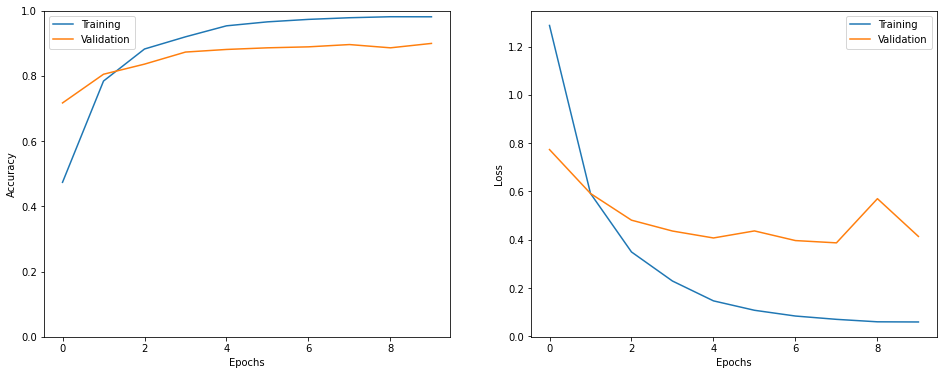

In [96]:
show_history(history)

In [97]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [98]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.3437 - accuracy: 0.9040


In [99]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  print('Predicted Emotion:', index_to_classes[np.argmax(p).astype('uint8')], '\n')


# i = random.randint(0, len(test_labels)-1)
# print('Sentence:', test_tweets[i])
# print('Emotion:', index_to_classes[test_labels[i]])
# p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
# pred_class = index_to_classes[np.argmax(p).astype('uint8')]
# print('Predicted Emotion:', pred_class)

Tweet: i did feel rather like a celebrity and widget stood and let herself be admired while she drank orange squash from my cup
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i think it s the opposite i get to feel defeated because i was doing everything possible to keep baby healthy and my sugars in check
Actual Emotion: sadness
Predicted Emotion: sadness 

Tweet: i just feel tender
Actual Emotion: love
Predicted Emotion: love 

Tweet: i was asked to toast with champagne at the death bed and i remember feeling disgusted
Actual Emotion: anger
Predicted Emotion: anger 

Tweet: i don t feel guilty like i m not going to be able to cook for him
Actual Emotion: sadness
Predicted Emotion: sadness 

